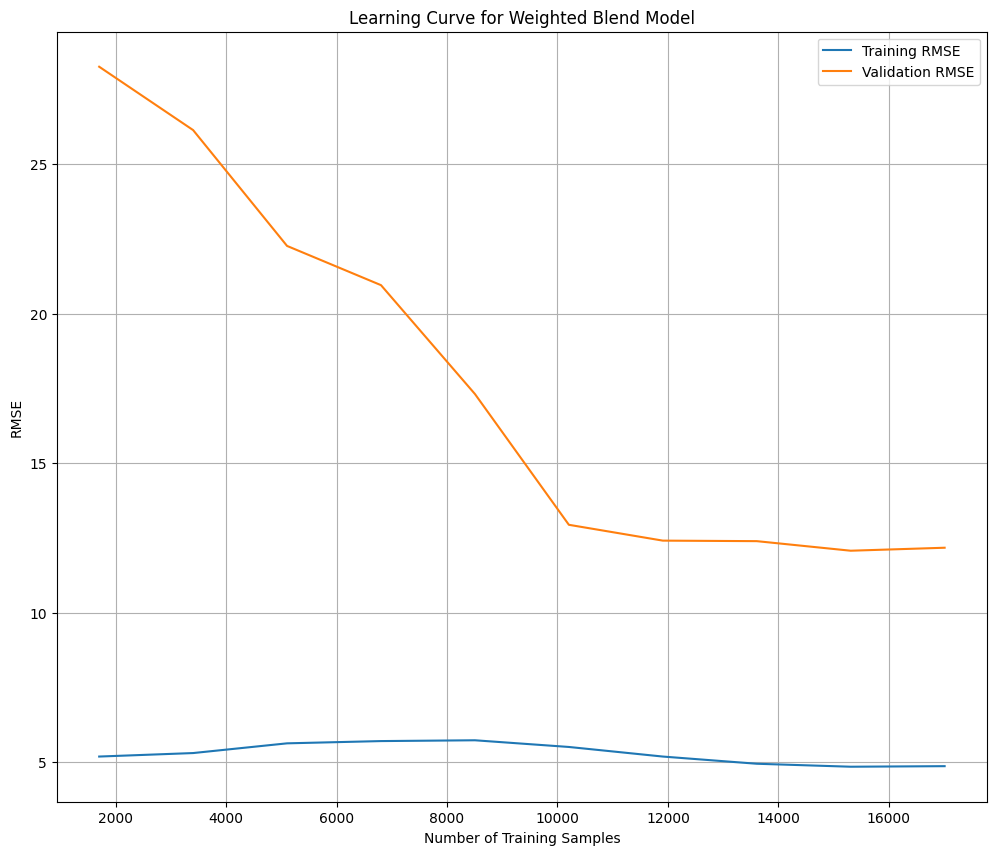

In [ ]:
# need to find out what is going on with the combined model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.base import BaseEstimator, RegressorMixin, clone
import lightgbm as lgb
import xgboost as xgb


# Load datasets
main_data = pd.read_csv("./data/train.csv")
unique_m = pd.read_csv("./data/unique_m.csv")

# Remove 'critical_temp' from unique_m to avoid duplication
unique_m = unique_m.drop(columns=["critical_temp"], errors='ignore')

# Merge datasets assuming rows align (index-based merge)
merged_data = pd.concat([main_data, unique_m], axis=1)

# Feature Engineering: Physics-Based Ratio, Thermal Conductivity Transformation, Log transformation
merged_data["mass_density_ratio"] = merged_data["wtd_mean_atomic_mass"] / (merged_data["wtd_mean_Density"] + 1e-9)
merged_data["affinity_valence_ratio"] = merged_data["wtd_mean_ElectronAffinity"] / (merged_data["wtd_mean_Valence"] + 1e-9)
merged_data["log_thermal_conductivity"] = np.log1p(merged_data["range_ThermalConductivity"])

# Define target and features
target = "critical_temp"
features = ['mean_atomic_mass', 'wtd_mean_atomic_mass', 'gmean_atomic_mass',
       'entropy_atomic_mass', 'wtd_entropy_atomic_mass', 'range_atomic_mass',
       'wtd_range_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie',
       'wtd_mean_fie', 'wtd_entropy_fie', 'range_fie', 'wtd_range_fie',
       'wtd_std_fie', 'mean_atomic_radius', 'wtd_mean_atomic_radius',
       'gmean_atomic_radius', 'range_atomic_radius', 'wtd_range_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density', 'entropy_Density',
       'wtd_entropy_Density', 'range_Density', 'wtd_range_Density',
       'wtd_std_Density', 'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_ElectronAffinity', 'wtd_gmean_ElectronAffinity',
       'entropy_ElectronAffinity', 'wtd_entropy_ElectronAffinity',
       'range_ElectronAffinity', 'wtd_range_ElectronAffinity',
       'wtd_std_ElectronAffinity', 'mean_FusionHeat', 'wtd_mean_FusionHeat',
       'gmean_FusionHeat', 'entropy_FusionHeat', 'wtd_entropy_FusionHeat',
       'range_FusionHeat', 'wtd_range_FusionHeat', 'wtd_std_FusionHeat',
       'mean_ThermalConductivity', 'wtd_mean_ThermalConductivity',
       'gmean_ThermalConductivity', 'wtd_gmean_ThermalConductivity',
       'entropy_ThermalConductivity', 'wtd_entropy_ThermalConductivity',
       'range_ThermalConductivity', 'wtd_range_ThermalConductivity',
       'mean_Valence', 'wtd_mean_Valence', 'range_Valence',
       'wtd_range_Valence', 'wtd_std_Valence', 'H', 'B', 'C', 'O', 'F', 'Na',
       'Mg', 'Al', 'Cl', 'K', 'Ca', 'V', 'Cr', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
       'As', 'Se', 'Sr', 'Y', 'Nb', 'Sn', 'I', 'Ba', 'La', 'Ce', 'Pr', 'Nd',
       'Sm', 'Eu', 'Gd', 'Tb', 'Yb', 'Hg', 'Tl', 'Pb', 'Bi',
       'mass_density_ratio', 'affinity_valence_ratio',
       'log_thermal_conductivity']

X = merged_data[features]
y = merged_data[target]

# no train test split, all goes to generating the learning curve

# optimized LightGBM Model
optimized_lgb_model = lgb.LGBMRegressor(n_estimators=496, max_depth=15, learning_rate=0.057878589503943714, 
                                  subsample=0.6619352139576826, colsample_bytree=0.7512301369524537, 
                                  num_leaves=148, force_col_wise=True, verbose=-1, random_state=42)

# optimized XGBoost Model
optimized_xgb_model = xgb.XGBRegressor(n_estimators=407, max_depth=10, learning_rate=0.02962746174406205,
                                 subsample=0.8786056663685927, colsample_bytree=0.6260167856358314,
                                 gamma=4.321388407974591, tree_method="hist", random_state=42)


# custom estimator for a weighted blend of two regressors so that instances can be called by learning_curve
class WeightedBlendRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model1, model2, weight1=0.5):
        self.model1 = model1
        self.model2 = model2
        self.weight1 = weight1  # weight for model1; model2 gets (1 - weight1)
        
    def fit(self, X, y):
        # clone the models to ensure independent fits on each call
        self.model1_ = clone(self.model1)
        self.model2_ = clone(self.model2)
        self.model1_.fit(X, y)
        self.model2_.fit(X, y)
        return self
    
    def predict(self, X):
        pred1 = self.model1_.predict(X)
        pred2 = self.model2_.predict(X)
        return self.weight1 * pred1 + (1 - self.weight1) * pred2
    

# define eval model as instance of estimator class with models and weight
weighted_blend = WeightedBlendRegressor(model1=optimized_xgb_model, model2=optimized_lgb_model, weight1=0.3454)


# use the entire dataset (X, y)
# use 10 points for training set sizes between 10% and 100% of the data
train_sizes, train_scores, val_scores = learning_curve(
    weighted_blend, X, y, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# convert negative RMSE scores to positive
train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

# plot the results
plt.figure(figsize=(12, 10))
plt.plot(train_sizes, train_rmse, label="Training RMSE")
plt.plot(train_sizes, val_rmse, label="Validation RMSE")
plt.xlabel("Number of Training Samples")
plt.ylabel("RMSE")
plt.title("Learning Curve for Weighted Blend Model")
plt.legend()
plt.grid(True)
plt.show()